In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
#importing libraries
import numpy as np
import pandas as pd
import os
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
import nltk
import re

In [39]:
train = pd.read_csv('/content/drive/MyDrive/reddit/train (1).csv')

In [40]:
train.head()

,Title,Post,Flair
0,netflix the family has been an amazing watch d...,netflixs new series the family is about a secr...,10
1,all results are out is iiitm gwalior it branch...,the internet seems to think so average package...,0
2,which are the things you always buy made in india,you can include the reason for your preference...,0
3,weekly coders hackers amp all tech related thr...,last week issue all threads every week on frid...,11
4,what are some good unknown companies to work a...,there are similar posts on other subreddits bu...,0


In [41]:
val = pd.read_csv('/content/drive/MyDrive/reddit/val (1).csv')

label_to_id={"AskIndia": 0, "Business/Finance": 1, "CAA-NRC": 2, "Coronavirus": 3, "Demonetization": 4, "Entertainment": 5, "Food": 6, "Non-Political": 7, "Photography": 8, "Policy/Economy": 9, "Politics": 10, "Scheduled": 11, "Science/Technology": 12, "Sports": 13, "[R]eddiquette": 14}
id_to_label={v: k for k, v in label_to_id.items()}
id_to_label

{0: 'AskIndia',
 1: 'Business/Finance',
 2: 'CAA-NRC',
 3: 'Coronavirus',
 4: 'Demonetization',
 5: 'Entertainment',
 6: 'Food',
 7: 'Non-Political',
 8: 'Photography',
 9: 'Policy/Economy',
 10: 'Politics',
 11: 'Scheduled',
 12: 'Science/Technology',
 13: 'Sports',
 14: '[R]eddiquette'}

In [42]:
flairs=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
#flairs = [‘AskIndia’, ‘Business/Finance’, ‘CAA-NRC’, ‘Coronavirus’, ‘Demonetization’, ‘Entertainment’, ‘Food’, ‘Non-Political’, ‘Photography’, ‘Policy/Economy’, ‘Politics’, ‘Scheduled’, ‘Science/Technology’, ‘Sports’, ‘[R]eddiquette’]

In [43]:
# for flair in id_to_label:
#     print (flair,': ' , len(train[train['Flair'] == flair]))

In [44]:
# for flair in flairs:
#     print (flair,': ' , len(val[val['Flair'] == flair]))

In [45]:
#removing nan values
empties = ['nan', '[deleted]', '[removed]']
for empty in empties:
  print(empty, len(train[train['Post'] == empty]))

train['Post'] = train['Post'].apply(lambda x: '' if x in empties else x)
val['Post'] = val['Post'].apply(lambda x: '' if x in empties else x)

empties = ['nan', '[deleted]', '[removed]']
for empty in empties:
  print(empty, len(train[train['Post'] == empty]))

nan 0
[deleted] 0
[removed] 0
nan 0
[deleted] 0
[removed] 0


In [46]:
#merging title and post as they convey the same thing
train['Title'] = train['Title'] + ' ' + train['Post']
val['Title'] = val['Title'] + ' ' + val['Post']

In [47]:
#removing extra characters, stopwords and lemmatizaing
from nltk.corpus import stopwords 
nltk.download('stopwords')
nltk.download('wordnet')
stop = set(stopwords.words('english'))
def remove_noise(text):

    # Step1: Make lowercase
    text = text.apply(lambda x: " ".join(x.lower() for x in str(x).split()))
    
    # Step2: Remove whitespaces
    text = text.apply(lambda x: " ".join(x.strip() for x in str(x).split()))

    # Step3 : Removing words inside brackets like "[OC]"
    text = text.apply(lambda x: re.sub(r"\[.*?\]", "", x))

    # Step4 : Removing everything from the data which is not alphanumeric.
    text = text.apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))

    # Step5 : Lemmatization
    lm=WordNetLemmatizer()
    text = text.apply(lambda x: lm.lemmatize(x))
    
    # Step6 : Removing Stopwords
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))

    # Convert to string
    text = text.astype(str)
        
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [48]:
train['Title'] = remove_noise(train['Title'])
val['Title'] = remove_noise(val['Title'])

In [66]:
#tokenizing texts 
# tokenizer = Tokenizer(lower=True, split=' ')
# tokenizer.fit_on_texts(train['Title'].values)
# tokenizer.fit_on_texts(val['Title'].values)
# sequences = tokenizer.texts_to_sequences(train['Title'].values)
# sequences_val = tokenizer.texts_to_sequences(val['Title'].values)
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=50)
train_ds = tf.data.Dataset.from_tensor_slices(train['Title']).batch(128)
val_ds = tf.data.Dataset.from_tensor_slices(val['Title']).batch(128)
vectorizer.adapt(train_ds)
vectorizer.adapt(val_ds)

In [50]:
#loading pre-trained GloVe embedding 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [67]:
#dict mapping words to their vector representation 
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [68]:
#dict mapping words to their indices 
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [69]:
#preparing embedding layer 
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18164 words (1836 misses)


In [70]:
#loading pre-trained word embedding matrix onto embedding layer
from tensorflow.keras.layers import Embedding
import keras

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [71]:
# MAX_LEN = 50
# padded_sequences = pad_sequences(sequences, padding='pre',maxlen=MAX_LEN)
# padded_sequences_val = pad_sequences(sequences_val,padding='pre',maxlen=MAX_LEN)

In [72]:
#building a model
voc_size = 1000000
embedding_vector_features=40
import keras.layers as L
from keras.models import Model
from keras.optimizers import Adam


In [73]:
train['Title']

0        netflix family amazing watch think rssvhp fami...
1        results iiitm gwalior branch good internet see...
2        things always buy made india include reason pr...
3        weekly coders hackers amp tech related thread ...
4        good unknown companies work india similar post...
                               ...                        
36542    start trading cryptocurrency india best option...
36543    may eat beef peace decided public ban whole sp...
36544    legal question metoo fully support metoo movem...
36545    andhra university alumni students sub invite j...
36546    ways generate passive income askindia need pas...
Name: Title, Length: 36547, dtype: object

In [74]:
#x_train,y_train,x_test,y_test split
train_samples = train['Title']
val_samples = val['Title']
train_labels = train['Flair']
val_labels = val['Flair']
#converting list of string data to array of integer indices. the arrays are right-padded 
x_train = vectorizer(np.array([[str(s)] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[str(s)] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [ ]:
import tensorflow as tf
MAX_FEATURES = 1000000
EMBED_SIZE = 40
RNN_CELL_SIZE = 32
MAX_LEN = 50  

class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [89]:
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
  
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
  
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)



lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)


state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(10)(lstm, state_h)
dense1 = Dense(64, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
dense2 = Dense(32, activation="relu")(dropout)
output = Dense(15, activation="softmax")(dropout)
model = keras.Model(inputs=sequence_input, outputs=output)
# model = Flatten()(model.output)


# summarize layers
print(model.summary())



# keras.utils.plot_model(model, show_shapes=True, dpi=90)





Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 50, 40)       40000000    input_3[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 50, 64)       18688       embedding_5[0][0]                
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 50, 64), (No 24832       bi_lstm_0[0][0]                  
____________________________________________________________________________________________

In [90]:
print(x_val.shape,y_val.shape)

(9001, 50) (9001,)


In [91]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 50, 40)       40000000    input_3[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 50, 64)       18688       embedding_5[0][0]                
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 50, 64), (No 24832       bi_lstm_0[0][0]                  
____________________________________________________________________________________________

In [92]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
 

In [99]:

BATCH_SIZE = 1000
EPOCHS = 10
history = model.fit(x_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val, y_val))

Epoch 1/10
37/37 [==============================] - 44s 1s/step - loss: 0.0426 - accuracy: 0.9869 - val_loss: 4.0820 - val_accuracy: 0.5004
Epoch 2/10
37/37 [==============================] - 44s 1s/step - loss: 0.0320 - accuracy: 0.9907 - val_loss: 4.1978 - val_accuracy: 0.5042
Epoch 3/10
37/37 [==============================] - 45s 1s/step - loss: 0.0294 - accuracy: 0.9910 - val_loss: 4.3269 - val_accuracy: 0.5027
Epoch 4/10
37/37 [==============================] - 45s 1s/step - loss: 0.0287 - accuracy: 0.9909 - val_loss: 4.4052 - val_accuracy: 0.5033
Epoch 5/10
37/37 [==============================] - 44s 1s/step - loss: 0.0277 - accuracy: 0.9909 - val_loss: 4.4932 - val_accuracy: 0.5038
Epoch 6/10
37/37 [==============================] - 44s 1s/step - loss: 0.0270 - accuracy: 0.9912 - val_loss: 4.5526 - val_accuracy: 0.5035
Epoch 7/10
37/37 [==============================] - 45s 1s/step - loss: 0.0262 - accuracy: 0.9913 - val_loss: 4.6259 - val_accuracy: 0.5041
Epoch 8/10
37/37 [==

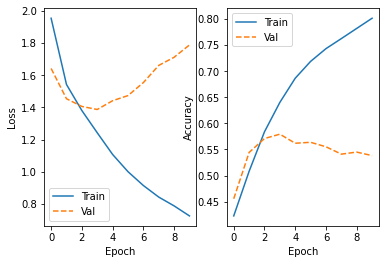

In [86]:
def plot_metrics(history):



    metrics = [
        "loss",


        "accuracy"
        
        
    ]

    for n, metric in  enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(1, 2, n + 1)
        plt.plot(
            history.epoch,
            history.history[metric],
            # color=colors[0],
            label="Train",
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            # color=colors[1],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        plt.legend()
plot_metrics(history)

In [ ]:
#val_accuracy max = 57